# About

Script to generate the figures pertaining to large-N dimensional numerics. Shows the plots over time for a single trial, and a compiled plot showing where multiple trials converge in terms of asymptotic frequency and variance. Import .mat files generated from 'sec4_ND_numerics.m'.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec4_ND_numerics2'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)

# Import data

## Parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

# Parameters
g = dict_mat['g'][0,0]
w0 = dict_mat['omega0'][0,0]
gain = dict_mat['gain'][0,0]
tau0 = dict_mat['tau0'][0,0]

parameters = {'g': g, 'omega0': w0, 'tau0': tau0, 'gain': gain}

asy = 0.1

## Theoretical frequencies

Obtain the theoretical curve $\Omega = \Omega(\delta)$.

In [4]:
# Fixed-point function
Omegafun = lambda Omega, delta: funlib.Omega_infty(Omega, delta, parameters, L=2*pi, steps=1000) - Omega

# Arrays
deltaarr = np.linspace(0,1, num=200)
Omegaarr = np.linspace(w0-g, w0+g, num=200)

# Obtain Omega = Omega(delta) function
Omegaroots = np.zeros(deltaarr.size)

initOmega = w0

for k in range(deltaarr.size):
    deltak = deltaarr[k]
    Omegafunk = lambda Omega: Omegafun(Omega, deltak)
    newroot = rootlib.find_root(Omegafunk, initOmega, w0-g, w0+g, steps=100)
    if newroot[1]:
        Omegaroots[k] = newroot[0]
        initOmega = newroot[0]

## Asymptotic values

In [5]:
# Chosen starting point
Omega_choose = w0
delta_choose = 0.5

DIST = 100

# Compiled arrays
initOmegas = np.zeros(len(filenames))
initstds = np.zeros(len(filenames))
asyOmegas = np.zeros(len(filenames))
asydeltas = np.zeros(len(filenames))
varOmegas = np.zeros(len(filenames))

for i in range(len(filenames)):
    
    # Import .mat file
    dir_mat = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_mat)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    initOmega = dict_mat['Omega0'][0,0]
    initstd = dict_mat['std'][0,0]
    
    # Compute the global frequency:
    arrOmega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asyOmega = np.sum(arrOmega) / arrOmega.size

    Omegavars = asylib.weight_avg(sol['t'], (sol['yp'] - asyOmega)**2, asy)
    Omegavar = np.sum(Omegavars)

    # Get array of asymptotic phases:
    arrlin = asyOmega*sol['t']
    arrlin = arrlin[:,None]

    arrphases = sol['y'] - arrlin
    asyphases = asylib.weight_avg(sol['t'], arrphases, asy)

    # Variance
    phasevars = asylib.weight_avg(sol['t'], (arrphases - asyphases)**2, asy)
    phasevar = np.mean(phasevars)
    
    N = asyphases.size
    asydelta = np.sqrt((N/(N-1))*np.var(asyphases))
    
    # Chosen plot
    dist = np.sqrt((initOmega - Omega_choose)**2 + (initstd - delta_choose)**2)
    if dist < DIST:
        DIST = dist
        Omega_plot = asyOmega
        delta_plot = asydelta
        phasestd_plot = np.sqrt(phasevar)
        initOmega_plot = initOmega
        initstd_plot = initstd
        
        sol_plot = sol.copy()
        phases_plot = arrphases
        asyphases_plot = asyphases
        
    # SAVE TO ARRAYS
    initOmegas[i] = initOmega
    initstds[i] = initstd
    asyOmegas[i] = asyOmega
    asydeltas[i] = asydelta
    varOmegas[i] = Omegavar
    
    sol = sol_plot

    # Print statements:
    # print("Trial: " + filenames[i] + ', init.Delta = ' + str(init_std))

## Process arrays for plots

In [6]:
# Sample which delay indices to plot:
NN = sol['tau'].shape[1]
num_inds = 50
inds = np.random.choice(np.arange(NN), size=num_inds, replace=False)

# Gaussian array
phasesarr_mod = asylib.mod_pi(asyphases_plot)
phasescenter = phasesarr_mod - np.average(phasesarr_mod)
L_dist = 5*np.sqrt(np.var(phasescenter))
num_bins = 30
distbins = np.linspace(-L_dist, L_dist, num=num_bins)

x_arr = np.linspace(-L_dist, L_dist, num=500)
y_arr = np.exp(-x_arr**2/(2*delta_plot**2)) / np.sqrt(2*pi*delta_plot**2)

# Plot

## Options

In [7]:
bbox0 = [0.10, 0.7, 0.3, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.10, 0.4, 0.3, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.10, 0.1, 0.3, 0.20] # Fig 2c: Delay plots
bbox3 = [0.50, 0.1, 0.40, 0.5] # Fig 2e: Iterated trial plot
bbox4 = [0.50, 0.7, 0.40, 0.2] # Fig 2d: Histogram plot with Gaussian fit

# Figures A, B, C
linewidth1 = 1.2
alpha1 = 0.4

t0 = np.min(sol['t'])
tf = np.max(sol['t'])

## Generate figures

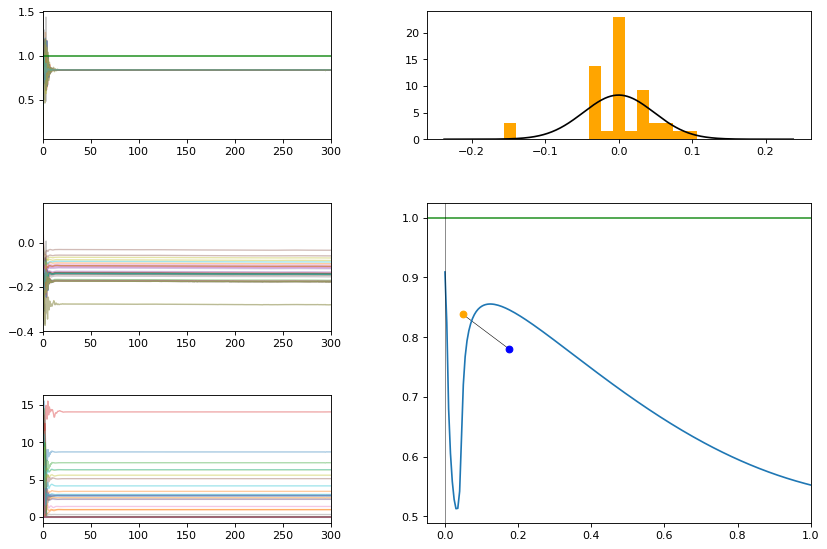

In [8]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Figures A, B, C (single trial)
ax[0].plot(sol['t'], sol['yp'], linewidth=linewidth1, alpha=alpha1, zorder=2)
ax[1].plot(sol['t'], np.sin(phases_plot), linewidth=linewidth1, alpha=alpha1, zorder=2)
ax[2].plot(sol['t'], sol['tau'][:,inds], linewidth=linewidth1, alpha=alpha1, zorder=2)

# Figure D
ax[4].plot(x_arr, y_arr, color='black', zorder=2)
ax[4].hist(phasescenter, bins=distbins, color='orange', density=True, zorder=1)

# Figure E
ax[3].plot(deltaarr, Omegaroots)
ax[3].scatter(initstds, initOmegas, color='blue', zorder=2)
ax[3].scatter(asydeltas, asyOmegas, color='orange', zorder=2)

for k in range(initOmegas.size):
    p1 = np.array([initOmegas[k], asyOmegas[k]])
    p2 = np.array([initstds[k], asydeltas[k]])
    ax[3].plot(p2, p1, color='black', linewidth=0.5, zorder=1)
    
# Edit plots
ax[0].set_xlim(left=t0, right=tf)
ax[1].set_xlim(left=t0, right=tf)
ax[2].set_xlim(left=t0, right=tf)
ax[3].set_xlim(left=-0.05, right=1.0)

ax[0].axhline(y=w0, color='green', alpha=0.8, linewidth=1.5)
ax[3].axhline(y=w0, color='green', alpha=0.8, linewidth=1.5)
ax[3].axvline(x=0, color='black', alpha=0.8, linewidth=0.5)

# Statistics

In [9]:
print(f'Asymptotic frequency = {Omega_plot}\n\
Asymptotic std = {delta_plot}\n\
Phase std = {phasestd_plot}\n\
Initial Omega = {initOmega_plot}\n\
Initial std = {initstd_plot}')

print("Shapiro-Wilk Test p-value: " + str(stats.shapiro(phasescenter)[1])) # High p-value implies normal distribution
print(parameters)

Asymptotic frequency = 0.838752692551371
Asymptotic std = 0.04813036847824787
Phase std = 0.0002782553784646142
Initial Omega = 0.7800382400865896
Initial std = 0.17596629348645493
Shapiro-Wilk Test p-value: 0.0023171519860625267
{'g': 1.5, 'omega0': 1, 'tau0': 0.1, 'gain': 80}


In [10]:
initOmegas

array([0.78003824])

In [11]:
np.zeros(2)

array([0., 0.])